In [1]:
%matplotlib notebook

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import subprocess
import nibabel as nib

import lib.data_generator as data_generator

In [2]:
n=64

# Import training data
data_path = '/data/vision/polina/scratch/nmsingh/imagenet-data-preprocessed-'+str(n)
training_generator = data_generator.DataSequence(data_path, 100, n)

In [3]:
# Set up model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/automap64-4gpu/cp-0015.ckpt')

In [4]:
# Generate k-space network input
def get_fft(img_array):
    img_fft = np.fft.fft2(img_array)
    img_fft_re = np.real(img_fft)
    img_fft_im = np.imag(img_fft)
    return np.stack([img_fft_re,img_fft_im],axis=-1)

In [5]:
# Reconstruction comparison plotting utilities
def plot_single_comparison(true_recon,our_recon,img_domain=True):
    fig,axes = plt.subplots( 1,3, figsize=[12,4] )
    if(img_domain):
        suffix = 'Reconstruction'
    else:
        suffix = 'k-space'
    for i,iax in enumerate(axes.flatten()):
        if i==0:
            iax.imshow(true_recon,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel('True '+suffix)
        elif i==1:
            iax.imshow(our_recon,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel('AutoMAP '+suffix)
        elif i==2:
            iax.imshow(true_recon-our_recon,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel('Difference')
    fig.show()
    
def plot_2domain_comparison(true_recon,our_recon):
    plot_single_comparison(true_recon,our_recon,True)
    plot_single_comparison(get_fft(true_recon)[:,:,0],get_fft(our_recon)[:,:,0],False)
    
def plot_dataset_comparison(dataset,i):
    if(dataset=='Train'):
        generator = training_generator
    else:
        raise ValueError('Misspecified dataset.')
        
    ex = generator[i]
    ex_in = ex[0]
    ex_out = model.predict(ex_in)

    true_img = ex[1][i,:,:,0]
    recon = ex_out[i,:,:,0]
    
    plot_2domain_comparison(true_img,recon)

<IPython.core.display.Javascript object>


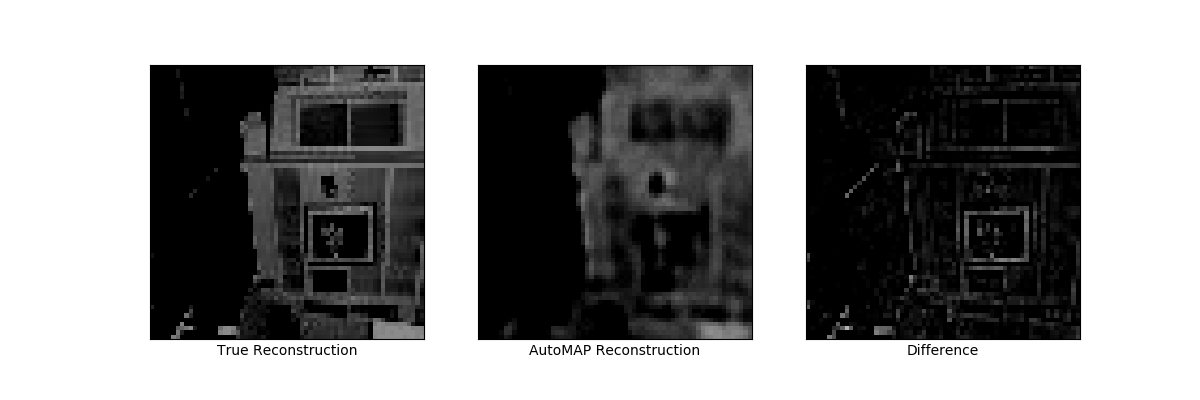

<IPython.core.display.Javascript object>


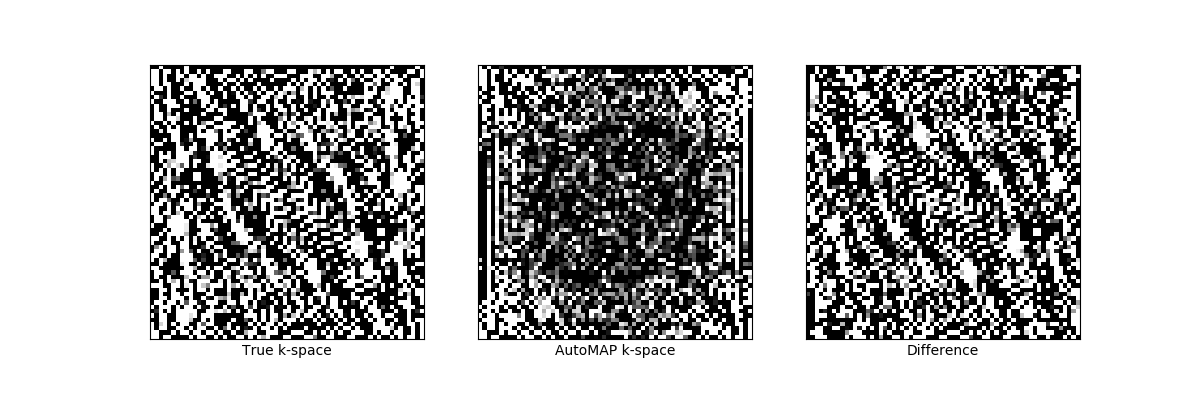

In [6]:
plot_dataset_comparison('Train',0)

<IPython.core.display.Javascript object>


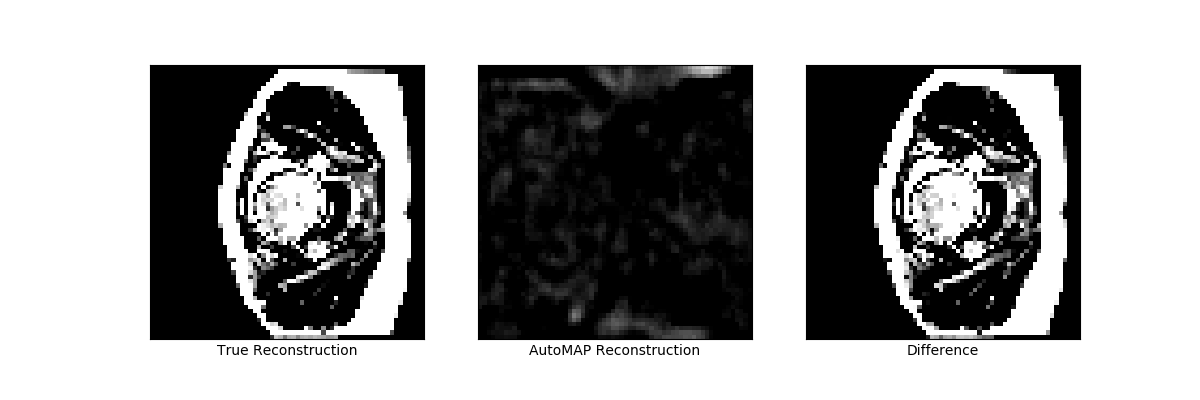

<IPython.core.display.Javascript object>


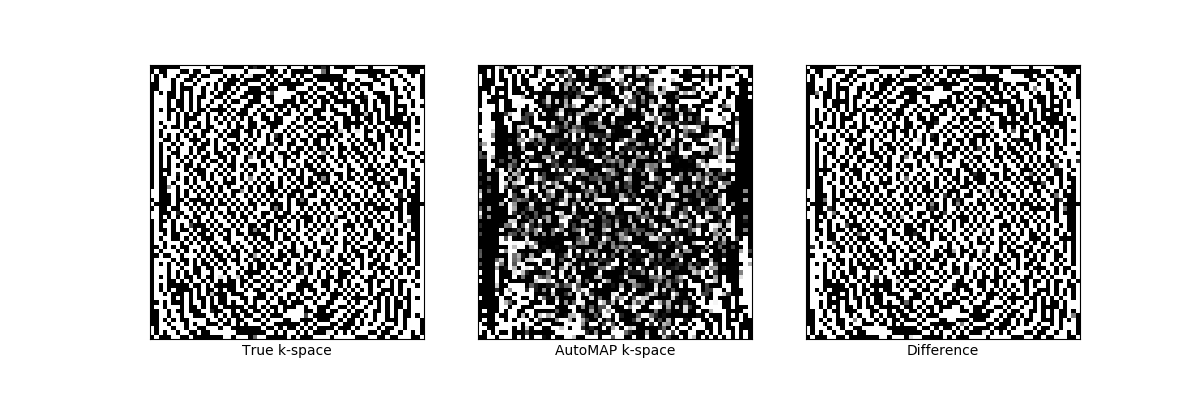

In [7]:
# Import fetal data
scannumber = 'MAP-C401-031615'
filename = 'PLACENTASTUDY_03162015_1.MR.0003_0000'
data_path = os.path.join('/data/vision/polina/projects/fetal_data/data/haste/Singleton-Control',scannumber,filename+'.nii.gz')
seg_path = os.path.join('/data/vision/polina/projects/fetal_data/data/haste/Singleton-Control-Segmentations',scannumber,filename+'-Segmentation-label.nii.gz')
img = nib.load(data_path).get_data()
sl = img[:,:,int(img.shape[2]/2)]
sl_downsample = res = cv2.resize(sl, dsize=(n, n), interpolation=cv2.INTER_CUBIC)
sl_downsample = sl_downsample-sl_downsample.mean()
sl_downsample = sl_downsample/255.
sl_k = np.expand_dims(get_fft(sl_downsample),0)

# Fetal comparisons
sl_pred = model.predict(sl_k)[0,:,:,0]
plot_2domain_comparison(sl_downsample,sl_pred)